<a href="https://colab.research.google.com/github/PratikshitSingh/Algotrading/blob/master/stock_prediction_using_LSTM_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
import os
datadir = "/content/drive/My Drive/Quant"
os.chdir(datadir)
!pwd

/content/drive/My Drive/Quant


In [53]:
#!unzip "preprocessed_CAC40.csv"

In [54]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [55]:
# Load csv
# This is preprocessed data created using the close price and volume traded
df = pd.read_csv('preprocessed_CAC40.csv', parse_dates=['Date'])

In [56]:
df.head()

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


In [57]:
df['Name'].unique()

array(['Accor', 'Air Liquide', 'Airbus ', 'ArcelorMittal', 'Atos', 'AXA',
       'BNP Paribas', 'Bouygues', 'Cap Gemini', 'Crédit Agricole',
       'Danone', 'Dassault Systèmes', 'Engie (ex GDF Suez',
       'EssilorLuxottica', 'Hermès (Hermes International', 'Kering',
       'LEGRAND', 'LOréal', 'LVMH Moet Hennessy Louis Vuitton',
       'Michelin (Compagnie Générale d Etablissements Michelin SCPA',
       'Orange', 'Pernod Ricard', 'Peugeot', 'Publicis', 'Renault',
       'SAFRAN', 'Saint-Gobain', 'Sanofi', 'Schneider Electric',
       'Société Générale (Societe Generale', 'Sodexo',
       'STMicroelectronics', 'TOTAL', 'Unibail-Rodamco',
       'Veolia Environnement', 'VINCI', 'Vivendi', 'Worldline SA'],
      dtype=object)

In [58]:
def load_data(company, start, end):
    """
    Load data for the specified company and date range.

    :param company: The company's stock symbol (str)
    :param start: The starting date for the data range (str or datetime)
    :param end: The ending date for the data range (str or datetime)
    :return: A dataframe containing the relevant stock data (pandas.DataFrame)
    """
    dataframe = df.copy()
    dataframe = dataframe.loc[dataframe.Name == company, :]
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    dataframe = dataframe.rename(columns = {'Closing_Price': 'Close'})
    return dataframe

In [59]:
COMPANY = 'Accor'
START_DATE = dt.datetime(2015,1,1)
END_DATE = dt.datetime(2020,1,1)

START_DATE_TEST = END_DATE

In [60]:
# Filter only data for Accor
data = load_data(company = COMPANY,
                 start = START_DATE,
                 end = END_DATE)

In [61]:
# Range of close price
data['Close'].max() - data['Close'].min()

20.03

In [62]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

sacled_data is just the array of data['close'] using the minmax transformation

In [63]:
# Range of close price after normalization
scaled_data.max() - scaled_data.min()

0.9999999999999998

In [64]:
# Set the number of days used for prediction
prediction_days = 60

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [65]:
x_train.shape

(1202, 60, 1)

In [66]:
def LSTM_model():
    """
    Create and configure an LSTM model for stock price prediction.

    :return: The configured LSTM model (keras.Sequential)
    """

    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=50, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=50))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

In [67]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam', 
    loss='mean_squared_error'
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [68]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5', 
    verbose = 2, 
    save_best_only = True
)

model.fit(
    x_train, 
    y_train, 
    epochs=150, 
    batch_size = 48,
    callbacks = [checkpointer]
)

Epoch 1/150
26/26 [==============================] - ETA: 0s - loss: 0.0460

26/26 [==============================] - 11s 118ms/step - loss: 0.0460
Epoch 2/150
26/26 [==============================] - ETA: 0s - loss: 0.0126

26/26 [==============================] - 3s 107ms/step - loss: 0.0126
Epoch 3/150
26/26 [==============================] - ETA: 0s - loss: 0.0105

26/26 [==============================] - 3s 109ms/step - loss: 0.0105
Epoch 4/150
26/26 [==============================] - ETA: 0s - loss: 0.0096

26/26 [==============================] - 4s 161ms/step - loss: 0.0096
Epoch 5/150
26/26 [==============================] - ETA: 0s - loss: 0.0088

26/26 [==============================] - 3s 132ms/step - loss: 0.0088
Epoch 6/150
26/26 [==============================] - ETA: 0s - loss: 0.0085

26/26 [==============================] - 3s 108ms/step - loss: 0.0085
Epoch 7/150
26/26 [==============================] - ETA: 0s - loss: 0.0096

26/26 [==============================] - 3s 111ms/step - loss: 0.0096
Epoch 8/150
26/26 [==============================] - ETA: 0s - loss: 0.0090

26/26 [==============================] - 3s 121ms/step - loss: 0.0090
Epoch 9/150
26/26 [==============================] - ETA: 0s - loss: 0.0082

26/26 [==============================] - 5s 173ms/step - loss: 0.0082
Epoch 10/150
26/26 [==============================] - ETA: 0s - loss: 0.0080

26/26 [==============================] - 3s 109ms/step - loss: 0.0080
Epoch 11/150
26/26 [==============================] - ETA: 0s - loss: 0.0076

26/26 [==============================] - 3s 111ms/step - loss: 0.0076
Epoch 12/150
26/26 [==============================] - ETA: 0s - loss: 0.0110

26/26 [==============================] - 3s 108ms/step - loss: 0.0110
Epoch 13/150
26/26 [==============================] - ETA: 0s - loss: 0.0077

26/26 [==============================] - 4s 162ms/step - loss: 0.0077
Epoch 14/150
26/26 [==============================] - ETA: 0s - loss: 0.0072

26/26 [==============================] - 4s 138ms/step - loss: 0.0072
Epoch 15/150
26/26 [==============================] - ETA: 0s - loss: 0.0071

26/26 [==============================] - 3s 112ms/step - loss: 0.0071
Epoch 16/150
26/26 [==============================] - ETA: 0s - loss: 0.0071

26/26 [==============================] - 3s 108ms/step - loss: 0.0071
Epoch 17/150
26/26 [==============================] - ETA: 0s - loss: 0.0067

26/26 [==============================] - 3s 131ms/step - loss: 0.0067
Epoch 18/150
26/26 [==============================] - ETA: 0s - loss: 0.0088

26/26 [==============================] - 4s 167ms/step - loss: 0.0088
Epoch 19/150
26/26 [==============================] - ETA: 0s - loss: 0.0066

26/26 [==============================] - 3s 111ms/step - loss: 0.0066
Epoch 20/150
26/26 [==============================] - ETA: 0s - loss: 0.0069

26/26 [==============================] - 3s 108ms/step - loss: 0.0069
Epoch 21/150
26/26 [==============================] - ETA: 0s - loss: 0.0060

26/26 [==============================] - 3s 109ms/step - loss: 0.0060
Epoch 22/150
26/26 [==============================] - ETA: 0s - loss: 0.0061

26/26 [==============================] - 4s 167ms/step - loss: 0.0061
Epoch 23/150
26/26 [==============================] - ETA: 0s - loss: 0.0060

26/26 [==============================] - 3s 127ms/step - loss: 0.0060
Epoch 24/150
26/26 [==============================] - ETA: 0s - loss: 0.0056

26/26 [==============================] - 3s 114ms/step - loss: 0.0056
Epoch 25/150
26/26 [==============================] - ETA: 0s - loss: 0.0056

26/26 [==============================] - 3s 108ms/step - loss: 0.0056
Epoch 26/150
26/26 [==============================] - ETA: 0s - loss: 0.0054

26/26 [==============================] - 3s 129ms/step - loss: 0.0054
Epoch 27/150
26/26 [==============================] - ETA: 0s - loss: 0.0057

26/26 [==============================] - 4s 165ms/step - loss: 0.0057
Epoch 28/150
26/26 [==============================] - ETA: 0s - loss: 0.0056

26/26 [==============================] - 3s 112ms/step - loss: 0.0056
Epoch 29/150
26/26 [==============================] - ETA: 0s - loss: 0.0054

26/26 [==============================] - 3s 117ms/step - loss: 0.0054
Epoch 30/150
26/26 [==============================] - ETA: 0s - loss: 0.0057

26/26 [==============================] - 3s 108ms/step - loss: 0.0057
Epoch 31/150
26/26 [==============================] - ETA: 0s - loss: 0.0048

26/26 [==============================] - 5s 177ms/step - loss: 0.0048
Epoch 32/150
26/26 [==============================] - ETA: 0s - loss: 0.0052

26/26 [==============================] - 3s 119ms/step - loss: 0.0052
Epoch 33/150
26/26 [==============================] - ETA: 0s - loss: 0.0051

26/26 [==============================] - 3s 110ms/step - loss: 0.0051
Epoch 34/150
26/26 [==============================] - ETA: 0s - loss: 0.0059

26/26 [==============================] - 3s 110ms/step - loss: 0.0059
Epoch 35/150
26/26 [==============================] - ETA: 0s - loss: 0.0053

26/26 [==============================] - 4s 141ms/step - loss: 0.0053
Epoch 36/150
26/26 [==============================] - ETA: 0s - loss: 0.0052

26/26 [==============================] - 4s 154ms/step - loss: 0.0052
Epoch 37/150
26/26 [==============================] - ETA: 0s - loss: 0.0047

26/26 [==============================] - 3s 117ms/step - loss: 0.0047
Epoch 38/150
26/26 [==============================] - ETA: 0s - loss: 0.0048

26/26 [==============================] - 3s 113ms/step - loss: 0.0048
Epoch 39/150
26/26 [==============================] - ETA: 0s - loss: 0.0049

26/26 [==============================] - 3s 110ms/step - loss: 0.0049
Epoch 40/150
26/26 [==============================] - ETA: 0s - loss: 0.0048

26/26 [==============================] - 5s 191ms/step - loss: 0.0048
Epoch 41/150
26/26 [==============================] - ETA: 0s - loss: 0.0055

26/26 [==============================] - 3s 108ms/step - loss: 0.0055
Epoch 42/150
26/26 [==============================] - ETA: 0s - loss: 0.0048

26/26 [==============================] - 3s 110ms/step - loss: 0.0048
Epoch 43/150
26/26 [==============================] - ETA: 0s - loss: 0.0044

26/26 [==============================] - 3s 113ms/step - loss: 0.0044
Epoch 44/150
26/26 [==============================] - ETA: 0s - loss: 0.0044

26/26 [==============================] - 4s 162ms/step - loss: 0.0044
Epoch 45/150
26/26 [==============================] - ETA: 0s - loss: 0.0041

26/26 [==============================] - 4s 141ms/step - loss: 0.0041
Epoch 46/150
26/26 [==============================] - ETA: 0s - loss: 0.0045

26/26 [==============================] - 3s 114ms/step - loss: 0.0045
Epoch 47/150
26/26 [==============================] - ETA: 0s - loss: 0.0050

26/26 [==============================] - 3s 119ms/step - loss: 0.0050
Epoch 48/150
26/26 [==============================] - ETA: 0s - loss: 0.0049

26/26 [==============================] - 4s 154ms/step - loss: 0.0049
Epoch 49/150
26/26 [==============================] - ETA: 0s - loss: 0.0041

26/26 [==============================] - 4s 163ms/step - loss: 0.0041
Epoch 50/150
26/26 [==============================] - ETA: 0s - loss: 0.0040

26/26 [==============================] - 3s 120ms/step - loss: 0.0040
Epoch 51/150
26/26 [==============================] - ETA: 0s - loss: 0.0042

26/26 [==============================] - 3s 120ms/step - loss: 0.0042
Epoch 52/150
26/26 [==============================] - ETA: 0s - loss: 0.0041

26/26 [==============================] - 4s 140ms/step - loss: 0.0041
Epoch 53/150
26/26 [==============================] - ETA: 0s - loss: 0.0039

26/26 [==============================] - 5s 172ms/step - loss: 0.0039
Epoch 54/150
26/26 [==============================] - ETA: 0s - loss: 0.0041

26/26 [==============================] - 3s 119ms/step - loss: 0.0041
Epoch 55/150
26/26 [==============================] - ETA: 0s - loss: 0.0036

26/26 [==============================] - 3s 126ms/step - loss: 0.0036
Epoch 56/150
26/26 [==============================] - ETA: 0s - loss: 0.0038

26/26 [==============================] - 4s 139ms/step - loss: 0.0038
Epoch 57/150
26/26 [==============================] - ETA: 0s - loss: 0.0038

26/26 [==============================] - 5s 176ms/step - loss: 0.0038
Epoch 58/150
26/26 [==============================] - ETA: 0s - loss: 0.0035

26/26 [==============================] - 3s 110ms/step - loss: 0.0035
Epoch 59/150
26/26 [==============================] - ETA: 0s - loss: 0.0037

26/26 [==============================] - 3s 114ms/step - loss: 0.0037
Epoch 60/150
26/26 [==============================] - ETA: 0s - loss: 0.0034

26/26 [==============================] - 3s 119ms/step - loss: 0.0034
Epoch 61/150
26/26 [==============================] - ETA: 0s - loss: 0.0039

26/26 [==============================] - 5s 187ms/step - loss: 0.0039
Epoch 62/150
26/26 [==============================] - ETA: 0s - loss: 0.0034

26/26 [==============================] - 3s 118ms/step - loss: 0.0034
Epoch 63/150
26/26 [==============================] - ETA: 0s - loss: 0.0035

26/26 [==============================] - 3s 117ms/step - loss: 0.0035
Epoch 64/150
26/26 [==============================] - ETA: 0s - loss: 0.0037

26/26 [==============================] - 3s 122ms/step - loss: 0.0037
Epoch 65/150
26/26 [==============================] - ETA: 0s - loss: 0.0035

26/26 [==============================] - 5s 178ms/step - loss: 0.0035
Epoch 66/150
26/26 [==============================] - ETA: 0s - loss: 0.0036

26/26 [==============================] - 4s 135ms/step - loss: 0.0036
Epoch 67/150
26/26 [==============================] - ETA: 0s - loss: 0.0034

26/26 [==============================] - 3s 118ms/step - loss: 0.0034
Epoch 68/150
26/26 [==============================] - ETA: 0s - loss: 0.0034

26/26 [==============================] - 4s 167ms/step - loss: 0.0034
Epoch 69/150
26/26 [==============================] - ETA: 0s - loss: 0.0034

26/26 [==============================] - 8s 304ms/step - loss: 0.0034
Epoch 70/150
26/26 [==============================] - ETA: 0s - loss: 0.0034

26/26 [==============================] - 7s 262ms/step - loss: 0.0034
Epoch 71/150
26/26 [==============================] - ETA: 0s - loss: 0.0031

26/26 [==============================] - 8s 296ms/step - loss: 0.0031
Epoch 72/150
26/26 [==============================] - ETA: 0s - loss: 0.0034

26/26 [==============================] - 3s 120ms/step - loss: 0.0034
Epoch 73/150
26/26 [==============================] - ETA: 0s - loss: 0.0033

26/26 [==============================] - 3s 118ms/step - loss: 0.0033
Epoch 74/150
26/26 [==============================] - ETA: 0s - loss: 0.0031

26/26 [==============================] - 4s 138ms/step - loss: 0.0031
Epoch 75/150
26/26 [==============================] - ETA: 0s - loss: 0.0031

26/26 [==============================] - 5s 176ms/step - loss: 0.0031
Epoch 76/150
26/26 [==============================] - ETA: 0s - loss: 0.0030

26/26 [==============================] - 3s 118ms/step - loss: 0.0030
Epoch 77/150
26/26 [==============================] - ETA: 0s - loss: 0.0029

26/26 [==============================] - 3s 120ms/step - loss: 0.0029
Epoch 78/150
26/26 [==============================] - ETA: 0s - loss: 0.0028

26/26 [==============================] - 4s 140ms/step - loss: 0.0028
Epoch 79/150
26/26 [==============================] - ETA: 0s - loss: 0.0031

26/26 [==============================] - 5s 181ms/step - loss: 0.0031
Epoch 80/150
26/26 [==============================] - ETA: 0s - loss: 0.0038

26/26 [==============================] - 3s 117ms/step - loss: 0.0038
Epoch 81/150
26/26 [==============================] - ETA: 0s - loss: 0.0033

26/26 [==============================] - 3s 123ms/step - loss: 0.0033
Epoch 82/150
26/26 [==============================] - ETA: 0s - loss: 0.0031

26/26 [==============================] - 3s 121ms/step - loss: 0.0031
Epoch 83/150
26/26 [==============================] - ETA: 0s - loss: 0.0028

26/26 [==============================] - 5s 195ms/step - loss: 0.0028
Epoch 84/150
26/26 [==============================] - ETA: 0s - loss: 0.0029

26/26 [==============================] - 3s 120ms/step - loss: 0.0029
Epoch 85/150
26/26 [==============================] - ETA: 0s - loss: 0.0029

26/26 [==============================] - 3s 120ms/step - loss: 0.0029
Epoch 86/150
26/26 [==============================] - ETA: 0s - loss: 0.0028

26/26 [==============================] - 3s 123ms/step - loss: 0.0028
Epoch 87/150
26/26 [==============================] - ETA: 0s - loss: 0.0026

26/26 [==============================] - 5s 194ms/step - loss: 0.0026
Epoch 88/150
26/26 [==============================] - ETA: 0s - loss: 0.0027

26/26 [==============================] - 3s 117ms/step - loss: 0.0027
Epoch 89/150
26/26 [==============================] - ETA: 0s - loss: 0.0027

26/26 [==============================] - 3s 120ms/step - loss: 0.0027
Epoch 90/150
26/26 [==============================] - ETA: 0s - loss: 0.0027

26/26 [==============================] - 3s 111ms/step - loss: 0.0027
Epoch 91/150
26/26 [==============================] - ETA: 0s - loss: 0.0026

26/26 [==============================] - 4s 159ms/step - loss: 0.0026
Epoch 92/150
26/26 [==============================] - ETA: 0s - loss: 0.0027

26/26 [==============================] - 4s 135ms/step - loss: 0.0027
Epoch 93/150
26/26 [==============================] - ETA: 0s - loss: 0.0036

26/26 [==============================] - 3s 110ms/step - loss: 0.0036
Epoch 94/150
26/26 [==============================] - ETA: 0s - loss: 0.0024

26/26 [==============================] - 3s 113ms/step - loss: 0.0024
Epoch 95/150
26/26 [==============================] - ETA: 0s - loss: 0.0026

26/26 [==============================] - 3s 125ms/step - loss: 0.0026
Epoch 96/150
26/26 [==============================] - ETA: 0s - loss: 0.0025

26/26 [==============================] - 4s 171ms/step - loss: 0.0025
Epoch 97/150
26/26 [==============================] - ETA: 0s - loss: 0.0025

26/26 [==============================] - 3s 110ms/step - loss: 0.0025
Epoch 98/150
26/26 [==============================] - ETA: 0s - loss: 0.0026

26/26 [==============================] - 3s 110ms/step - loss: 0.0026
Epoch 99/150
26/26 [==============================] - ETA: 0s - loss: 0.0024

26/26 [==============================] - 3s 128ms/step - loss: 0.0024
Epoch 100/150
26/26 [==============================] - ETA: 0s - loss: 0.0024

26/26 [==============================] - 5s 177ms/step - loss: 0.0024
Epoch 101/150
26/26 [==============================] - ETA: 0s - loss: 0.0025

26/26 [==============================] - 3s 119ms/step - loss: 0.0025
Epoch 102/150
26/26 [==============================] - ETA: 0s - loss: 0.0025

26/26 [==============================] - 3s 110ms/step - loss: 0.0025
Epoch 103/150
26/26 [==============================] - ETA: 0s - loss: 0.0026

26/26 [==============================] - 3s 112ms/step - loss: 0.0026
Epoch 104/150
26/26 [==============================] - ETA: 0s - loss: 0.0026

26/26 [==============================] - 4s 141ms/step - loss: 0.0026
Epoch 105/150
26/26 [==============================] - ETA: 0s - loss: 0.0025

26/26 [==============================] - 4s 152ms/step - loss: 0.0025
Epoch 106/150
26/26 [==============================] - ETA: 0s - loss: 0.0025

26/26 [==============================] - 3s 133ms/step - loss: 0.0025
Epoch 107/150
26/26 [==============================] - ETA: 0s - loss: 0.0023

26/26 [==============================] - 3s 110ms/step - loss: 0.0023
Epoch 108/150
26/26 [==============================] - ETA: 0s - loss: 0.0024

26/26 [==============================] - 3s 119ms/step - loss: 0.0024
Epoch 109/150
26/26 [==============================] - ETA: 0s - loss: 0.0024

26/26 [==============================] - 5s 177ms/step - loss: 0.0024
Epoch 110/150
26/26 [==============================] - ETA: 0s - loss: 0.0022

26/26 [==============================] - 3s 110ms/step - loss: 0.0022
Epoch 111/150
26/26 [==============================] - ETA: 0s - loss: 0.0021

26/26 [==============================] - 3s 112ms/step - loss: 0.0021
Epoch 112/150
26/26 [==============================] - ETA: 0s - loss: 0.0024

26/26 [==============================] - 3s 112ms/step - loss: 0.0024
Epoch 113/150
26/26 [==============================] - ETA: 0s - loss: 0.0022

26/26 [==============================] - 4s 161ms/step - loss: 0.0022
Epoch 114/150
26/26 [==============================] - ETA: 0s - loss: 0.0021

26/26 [==============================] - 4s 135ms/step - loss: 0.0021
Epoch 115/150
26/26 [==============================] - ETA: 0s - loss: 0.0021

26/26 [==============================] - 3s 111ms/step - loss: 0.0021
Epoch 116/150
26/26 [==============================] - ETA: 0s - loss: 0.0023

26/26 [==============================] - 3s 112ms/step - loss: 0.0023
Epoch 117/150
26/26 [==============================] - ETA: 0s - loss: 0.0021

26/26 [==============================] - 3s 130ms/step - loss: 0.0021
Epoch 118/150
26/26 [==============================] - ETA: 0s - loss: 0.0022

26/26 [==============================] - 4s 168ms/step - loss: 0.0022
Epoch 119/150
26/26 [==============================] - ETA: 0s - loss: 0.0022

26/26 [==============================] - 3s 113ms/step - loss: 0.0022
Epoch 120/150
26/26 [==============================] - ETA: 0s - loss: 0.0021

26/26 [==============================] - 3s 111ms/step - loss: 0.0021
Epoch 121/150
26/26 [==============================] - ETA: 0s - loss: 0.0021

26/26 [==============================] - 3s 112ms/step - loss: 0.0021
Epoch 122/150
26/26 [==============================] - ETA: 0s - loss: 0.0021

26/26 [==============================] - 4s 170ms/step - loss: 0.0021
Epoch 123/150
26/26 [==============================] - ETA: 0s - loss: 0.0020

26/26 [==============================] - 3s 124ms/step - loss: 0.0020
Epoch 124/150
26/26 [==============================] - ETA: 0s - loss: 0.0022

26/26 [==============================] - 3s 116ms/step - loss: 0.0022
Epoch 125/150
26/26 [==============================] - ETA: 0s - loss: 0.0020

26/26 [==============================] - 3s 114ms/step - loss: 0.0020
Epoch 126/150
26/26 [==============================] - ETA: 0s - loss: 0.0020

26/26 [==============================] - 4s 141ms/step - loss: 0.0020
Epoch 127/150
26/26 [==============================] - ETA: 0s - loss: 0.0021

26/26 [==============================] - 4s 156ms/step - loss: 0.0021
Epoch 128/150
26/26 [==============================] - ETA: 0s - loss: 0.0020

26/26 [==============================] - 3s 113ms/step - loss: 0.0020
Epoch 129/150
26/26 [==============================] - ETA: 0s - loss: 0.0019

26/26 [==============================] - 3s 112ms/step - loss: 0.0019
Epoch 130/150
26/26 [==============================] - ETA: 0s - loss: 0.0023

26/26 [==============================] - 3s 114ms/step - loss: 0.0023
Epoch 131/150
26/26 [==============================] - ETA: 0s - loss: 0.0019

26/26 [==============================] - 6s 220ms/step - loss: 0.0019
Epoch 132/150
26/26 [==============================] - ETA: 0s - loss: 0.0020

26/26 [==============================] - 3s 111ms/step - loss: 0.0020
Epoch 133/150
26/26 [==============================] - ETA: 0s - loss: 0.0020

26/26 [==============================] - 3s 111ms/step - loss: 0.0020
Epoch 134/150
26/26 [==============================] - ETA: 0s - loss: 0.0020

26/26 [==============================] - 3s 113ms/step - loss: 0.0020
Epoch 135/150
26/26 [==============================] - ETA: 0s - loss: 0.0019

26/26 [==============================] - 5s 180ms/step - loss: 0.0019
Epoch 136/150
26/26 [==============================] - ETA: 0s - loss: 0.0019

26/26 [==============================] - 3s 117ms/step - loss: 0.0019
Epoch 137/150
26/26 [==============================] - ETA: 0s - loss: 0.0020

26/26 [==============================] - 3s 113ms/step - loss: 0.0020
Epoch 138/150
26/26 [==============================] - ETA: 0s - loss: 0.0019

26/26 [==============================] - 3s 112ms/step - loss: 0.0019
Epoch 139/150
26/26 [==============================] - ETA: 0s - loss: 0.0019

26/26 [==============================] - 4s 150ms/step - loss: 0.0019
Epoch 140/150
26/26 [==============================] - ETA: 0s - loss: 0.0018

26/26 [==============================] - 4s 149ms/step - loss: 0.0018
Epoch 141/150
26/26 [==============================] - ETA: 0s - loss: 0.0023

26/26 [==============================] - 3s 113ms/step - loss: 0.0023
Epoch 142/150
26/26 [==============================] - ETA: 0s - loss: 0.0022

26/26 [==============================] - 3s 112ms/step - loss: 0.0022
Epoch 143/150
26/26 [==============================] - ETA: 0s - loss: 0.0019

26/26 [==============================] - 3s 118ms/step - loss: 0.0019
Epoch 144/150
26/26 [==============================] - ETA: 0s - loss: 0.0017

26/26 [==============================] - 5s 180ms/step - loss: 0.0017
Epoch 145/150
26/26 [==============================] - ETA: 0s - loss: 0.0019

26/26 [==============================] - 3s 113ms/step - loss: 0.0019
Epoch 146/150
26/26 [==============================] - ETA: 0s - loss: 0.0020

26/26 [==============================] - 3s 113ms/step - loss: 0.0020
Epoch 147/150
26/26 [==============================] - ETA: 0s - loss: 0.0018

26/26 [==============================] - 3s 113ms/step - loss: 0.0018
Epoch 148/150
26/26 [==============================] - ETA: 0s - loss: 0.0019

26/26 [==============================] - 4s 168ms/step - loss: 0.0019
Epoch 149/150
26/26 [==============================] - ETA: 0s - loss: 0.0019

26/26 [==============================] - 4s 133ms/step - loss: 0.0019
Epoch 150/150
26/26 [==============================] - ETA: 0s - loss: 0.0019

26/26 [==============================] - 3s 112ms/step - loss: 0.0019


In [ ]:
%tensorboard --logdir logs/scalars

In [69]:
# Load test data for the specified company and date range
test_data = load_data(
    company=COMPANY,
    start=START_DATE_TEST,
    end=dt.datetime.now()
)

# Extract the actual closing prices from the test data
actual_prices = test_data['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)

In [70]:
# Initialize an empty list for test data input
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

3/3 [==============================] - 1s 22ms/step


## Test Data plotting

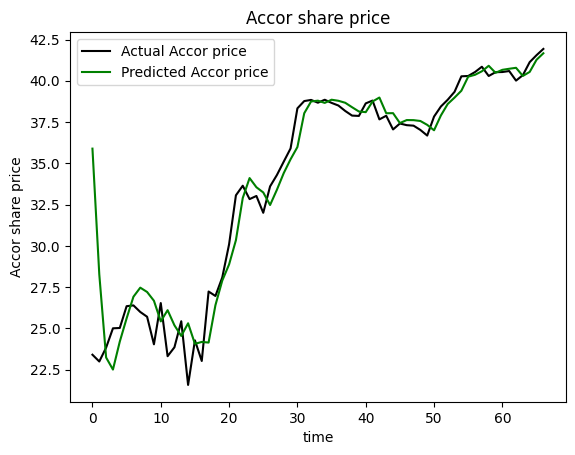

In [71]:
# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted {COMPANY} price")

# Set the title of the plot using the company name
plt.title(f"{COMPANY} share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"{COMPANY} share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [72]:
# Extract the last 'prediction_days' values from the model inputs
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data)

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console
print(f"Prediction: {prediction[0][0]}")

1/1 [==============================] - 1s 1s/step
Prediction: 41.996578216552734


# Multvariate time-series prediction